In [1]:
## follow the tutorial on https://github.com/boxiangliu/enformer

import tensorflow as tf
import tensorflow_hub as hub
import joblib
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

2023-06-13 16:49:08.867132: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/slurm-20.11.0/lib64:/opt/slurm/pe2/slurm/centos7/lib64:/opt/slurm/slurm-20.11.0/lib64:/opt/slurm/slurm-20.11.0/lib64:
2023-06-13 16:49:08.867207: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-13 16:49:24.873891: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/slurm-20.11.0/lib64:/opt/slurm/pe2/slurm/centos7/lib64:/opt/slurm/slurm-20.11.0/lib64:/opt/slurm/slurm-20.11.0/lib64:
2023-06-13 16:49:24.874232: W tensorflow/compiler/xla

In [2]:
## set everything up
## the fasta_file here is hg38

transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
model_path = 'https://tfhub.dev/deepmind/enformer/1'
fasta_file = '/gpfs/commons/home/tlin/data/enformer/hg38.fa'
clinvar_vcf = '/gpfs/commons/home/tlin/data/enformer/clinvar.vcf.gz'


# Download targets from Basenji2 dataset 
# Cite: Kelley et al Cross-species regulatory sequence activity prediction. PLoS Comput. Biol. 16, e1008050 (2020).
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')
df_targets.head(3)

pyfaidx.Faidx(fasta_file)

Faidx("/gpfs/commons/home/tlin/data/enformer/hg38.fa")

## Build Enformer, EnformerScoreVariantsNormalized, EnformerScoreVariantsPCANormalized

In [4]:
# @title `Enformer`, `EnformerScoreVariantsNormalized`, `EnformerScoreVariantsPCANormalized`,
SEQUENCE_LENGTH = 393216

class Enformer:

  def __init__(self, tfhub_url):
    self._model = hub.load(tfhub_url).model

  def predict_on_batch(self, inputs):
    predictions = self._model.predict_on_batch(inputs)
    return {k: v.numpy() for k, v in predictions.items()}

  @tf.function
  def contribution_input_grad(self, input_sequence,
                              target_mask, output_head='human'):
    input_sequence = input_sequence[tf.newaxis]

    target_mask_mass = tf.reduce_sum(target_mask)
    with tf.GradientTape() as tape:
      tape.watch(input_sequence)
      prediction = tf.reduce_sum(
          target_mask[tf.newaxis] *
          self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

    input_grad = tape.gradient(prediction, input_sequence) * input_sequence
    input_grad = tf.squeeze(input_grad, axis=0)
    return tf.reduce_sum(input_grad, axis=-1)


class EnformerScoreVariantsRaw:

  def __init__(self, tfhub_url, organism='human'):
    self._model = Enformer(tfhub_url)
    self._organism = organism
  
  def predict_on_batch(self, inputs):
    ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
    alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]

    return alt_prediction.mean(axis=1) - ref_prediction.mean(axis=1)


class EnformerScoreVariantsNormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human'):
    assert organism == 'human', 'Transforms only compatible with organism=human'
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      transform_pipeline = joblib.load(f)
    self._transform = transform_pipeline.steps[0][1]  # StandardScaler.
    
  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)


class EnformerScoreVariantsPCANormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human', num_top_features=500):
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      self._transform = joblib.load(f)
    self._num_top_features = num_top_features
    
  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)[:, :self._num_top_features]


## Variant_centered_sequences

In [5]:
class FastaStringExtractor:
    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()


def variant_generator(vcf_file, gzipped=False):
  """Yields a kipoiseq.dataclasses.Variant for each row in VCF file."""
  def _open(file):
    return gzip.open(vcf_file, 'rt') if gzipped else open(vcf_file)
    
  with _open(vcf_file) as f:
    for line in f:
      if line.startswith('#'):
        continue
      chrom, pos, id, ref, alt_list = line.split('\t')[:5]
      # Split ALT alleles and return individual variants as output.
      for alt in alt_list.split(','):
        yield kipoiseq.dataclasses.Variant(chrom=chrom, pos=pos,
                                           ref=ref, alt=alt, id=id)


def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)


def variant_centered_sequences(vcf_file, sequence_length, gzipped=False,
                               chr_prefix=''):
  seq_extractor = kipoiseq.extractors.VariantSeqExtractor(
    reference_sequence=FastaStringExtractor(fasta_file))

  for variant in variant_generator(vcf_file, gzipped=gzipped):
    interval = Interval(chr_prefix + variant.chrom,
                        variant.pos, variant.pos)
    interval = interval.resize(sequence_length)
    center = interval.center() - interval.start

    reference = seq_extractor.extract(interval, [], anchor=center)
    alternate = seq_extractor.extract(interval, [variant], anchor=center)

    yield {'inputs': {'ref': one_hot_encode(reference),
                      'alt': one_hot_encode(alternate)},
           'metadata': {'chrom': chr_prefix + variant.chrom,
                        'pos': variant.pos,
                        'id': variant.id,
                        'ref': variant.ref,
                        'alt': variant.alt}}
    
    
def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()

## Make predictions for a genetic sequence interval (using .fa)

In [20]:
model = Enformer(model_path)
fasta_extractor = FastaStringExtractor("/gpfs/commons/home/tlin/data/enformer/hg38.fa")
fasta_file = "/gpfs/commons/home/tlin/data/enformer/hg38.fa"


## fasta_extractor predictions for an genomic example interval
## TRY SCO2 as example (# CHR22)

# target_interval = kipoiseq.Interval('chr22', 50525606+buffer, 50525606 - buffer)  # @param
# sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
# predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]


## make this a function
## start and end here means the range you want to see in the plot
def prediction_from_fa (chr_num, tss, plot=True):
    chr_num, tss = str(chr_num), str(tss)
    if("," in tss):
        tss = tss.replace(",","_")
    SEQUENCE_LENGTH = 393216
    BUFFER=196608
    target_interval = kipoiseq.Interval(chr_num, int(tss)+buffer, int(tss)-buffer)
    sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
    predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]
    
    tracks = {'CAGE: Brain, adult':  np.log10(1 + predictions[:, 4680]),
          'CAGE:Dendritic Cells - monocyte immature derived': np.log10(1 + predictions[:, 4761]),
          'CAGE:B lymphoblastoid cell line': np.log10(1 + predictions[:, 5110]),
          'CAGE:Astrocyte - cerebellum': np.log10(1 + predictions[:, 4873]),
          'CAGE:skin, adult': np.log10(1 + predictions[:, 4970])}

    if plot:
        plot_tracks(tracks, target_interval)
    return(predictions)

array([[3.7339124e-01, 4.8611027e-01, 1.0842899e+00, ..., 3.6828898e-02,
        1.3117819e-01, 1.8900688e-01],
       [3.8856658e-01, 5.3938407e-01, 1.0959427e+00, ..., 9.0023473e-02,
        5.4359925e-01, 9.5683002e-01],
       [4.0412030e-01, 5.2830374e-01, 1.0579349e+00, ..., 8.8146618e-03,
        2.6163599e-02, 2.4970116e-02],
       ...,
       [6.0381341e+00, 5.4910674e+00, 5.8814664e+00, ..., 1.2875443e+00,
        1.1085203e+01, 7.1725454e+00],
       [3.1293464e+00, 2.9082792e+00, 3.5169451e+00, ..., 5.8211285e-01,
        7.1945882e+00, 3.5421352e+00],
       [3.3752292e-01, 3.4219807e-01, 2.9080138e-01, ..., 1.4393581e-01,
        1.6528419e+00, 1.2000110e+00]], dtype=float32)

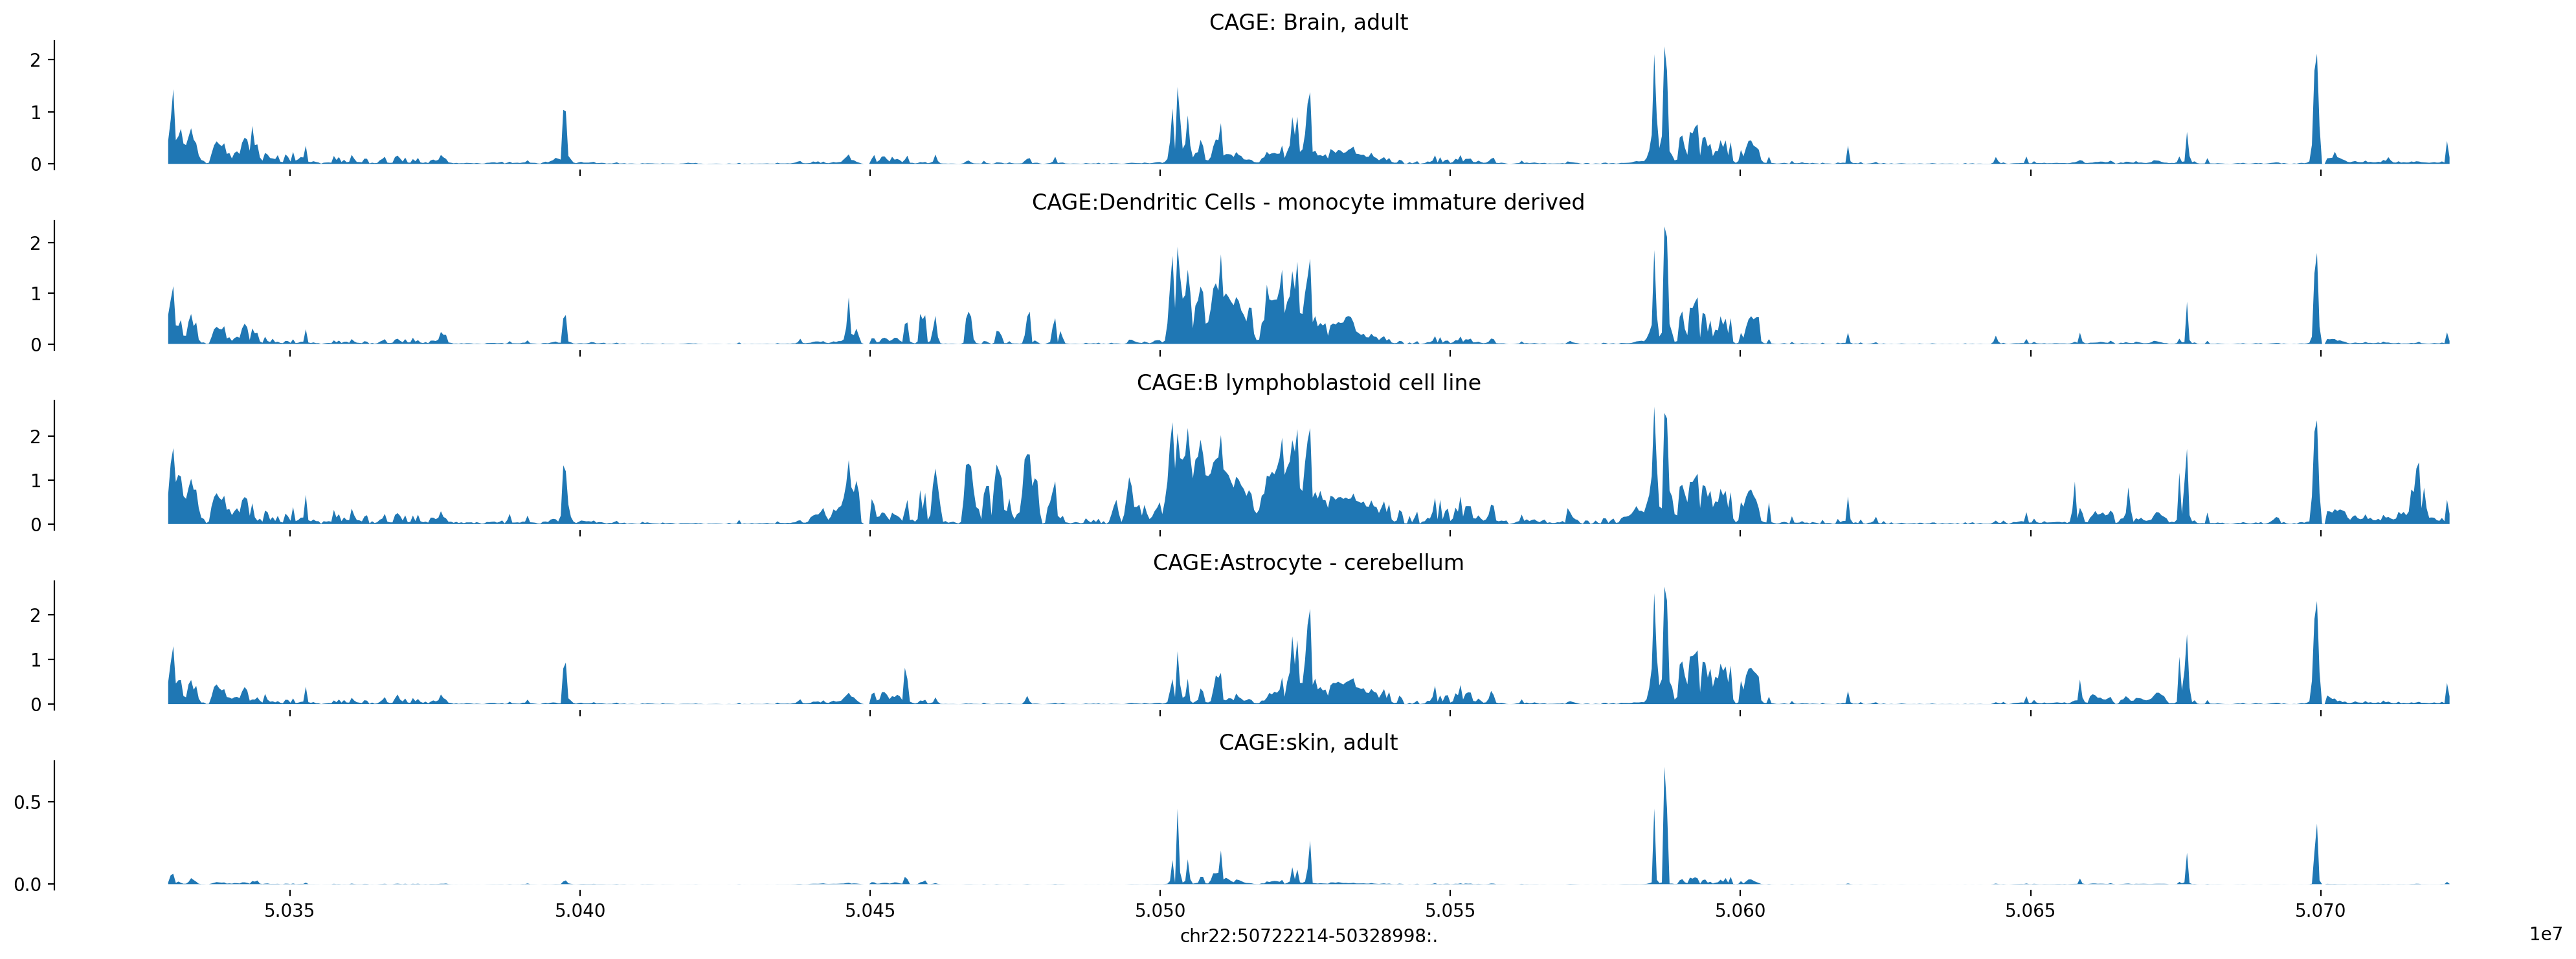

In [21]:
prediction_from_fa('chr22', 50525606)

## Make predictions for a genetic sequence interval (using vcf)

In [24]:
from cyvcf2 import VCF
df_1KG = SampleSeqExtractor(fasta_file, chr22_vcf)

vcf_path='/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/ADSP_vcf/36K_preview/annotated_chunk'
chr22_vcf=vcf_path+'/ADSP.chr22.chunk1.vcf.bgz'
fasta_file = "/gpfs/commons/home/tlin/data/enformer/hg38.fa"

In [25]:
## Chirag's code
from kipoiseq.extractors import VariantSeqExtractor
class SampleSeqExtractor(VariantSeqExtractor):
    def __init__(self, fasta_file, vcf_file):
        """Sequence extractor which can extract an alternate sequence for a
        given interval and the variants corresponding to a given
        sample and phase.
        Args:
          fasta_file: Path to the fasta file containing the reference
            sequence (can be gzipped)
          vcf_file: Path to the VCF file containing phased genotype information
        """
        self.vcf = VCF(vcf_file)
        self._sample_indices = dict(zip(self.vcf.samples,
                                        range(len(self.vcf.samples))))
        super().__init__(fasta_file)
    def extract(self, interval, sample, phase, anchor,
                fixed_len=True, **kwargs):
        """Extracts an alternate sequence for a given interval and the
        variants corresponding to a given sample.
        Args:
          interval: `kipoiseq.dataclasses.Interval`, Region of
            interest from which to query the sequence. 0-based.
          sample: `str`, Sample from the VCF file for which variants should be
            extracted.
          phase: `0` or `1`, Phase for which sequence should be extracted
          anchor: `int`, Absolution position w.r.t. the interval
            start. (0-based).  E.g. for an interval of `chr1:10-20`
            the anchor of 10 denotes the point chr1:10 in the 0-based
            coordinate system.
          fixed_len: `bool`, If True, the return sequence will have the
            same length as the `interval` (e.g. `interval.end -
            interval.start`)
          kwargs: Additional keyword arguments to pass to
            `SampleSeqExtractor.extract`
        Returns:
          A single sequence (`str`) with all the variants applied.
        """
        variants = []
        if sample is not None:
            if sample not in self.vcf.samples:
                raise ValueError(f'Sample {sample} not present in VCF file')
            if phase not in (0, 1):
                raise ValueError('phase argument must be in (0, 1) if sample is not None')
            # Interval is  0-based, cyvcf2 positions are 1-based: need to add 1
            variants = self._get_sample_variants(
                self.vcf(f'{interval.chrom}:'
                    + f'{interval.start + 1}-{interval.end + 1}'
                ),
                sample,
                phase
            )
        return super(SampleSeqExtractor, self).extract(
            interval, variants, anchor, fixed_len, **kwargs)
    def _get_sample_variants(self, variants, sample, phase):
        """Given a list of `cyvcf2.Variant`, returns all those present for a
        given sample and phase and converts them to
        `kipoiseq.dataclasses.Variant`
        Args:
          variants: List of `cyvcf2.Variant`, Variants of interest
          sample: `str`, Sample for which to filter genotypes
          phase: `0` or `1`, Phase for which to filter genotypes
        Returns:
          List of `kipoiseq.dataclasses.Variant`
        """
        sample_index = self._sample_indices[sample]
        return [
            Variant.from_cyvcf(v) for v in variants
            if v.genotypes[sample_index][phase]
        ]



In [ ]:
SampleSeqExtractor

In [8]:
enformer_score_variants_Normalized = EnformerScoreVariantsNormalized(model_path, transform_path)

test = variant_centered_sequences(chr22_vcf, sequence_length=SEQUENCE_LENGTH,
                                gzipped=True, chr_prefix='')
enformer_score_variants = EnformerScoreVariantsPCANormalized(model_path, transform_path, num_top_features=20)


test = variant_centered_sequences(chr22_vcf, sequence_length=SEQUENCE_LENGTH,
                                gzipped=True, chr_prefix='')
## report top 20 pcs
enformer_score_variants = EnformerScoreVariantsPCANormalized(model_path, transform_path, num_top_features=20)
example_list = []
for i, example in enumerate(test):
  if i >= 5:
    break
  variant_scores = enformer_score_variants.predict_on_batch(
      {k: v[tf.newaxis] for k,v in example['inputs'].items()})[0]
  variant_scores = {f'PC{i}': score for i, score in enumerate(variant_scores)}
  example_list.append({**example['metadata'],
                       **variant_scores})
df = pd.DataFrame(example_list)
df

## Variant scoring

In [ ]:
# @title Score the variant
variant = kipoiseq.Variant('chr2', 127077657, 'C', 'T', id='rs4663105')  # @param

# Center the interval at the variant 
## check up/downstream 196,608 bp
interval = kipoiseq.Interval(variant.chrom, variant.start, variant.start).resize(SEQUENCE_LENGTH)
seq_extractor = kipoiseq.extractors.VariantSeqExtractor(reference_sequence=fasta_extractor)
center = interval.center() - interval.start  ##but shouldnt the center always be SEQUENCE_LENGTH/2

reference = seq_extractor.extract(interval, [], anchor=center)  ##393216
alternate = seq_extractor.extract(interval, [variant], anchor=center)

# Make predictions for the refernece and alternate allele
reference_prediction = model.predict_on_batch(one_hot_encode(reference)[np.newaxis])['human'][0]  #(896, 5313)
alternate_prediction = model.predict_on_batch(one_hot_encode(alternate)[np.newaxis])['human'][0]

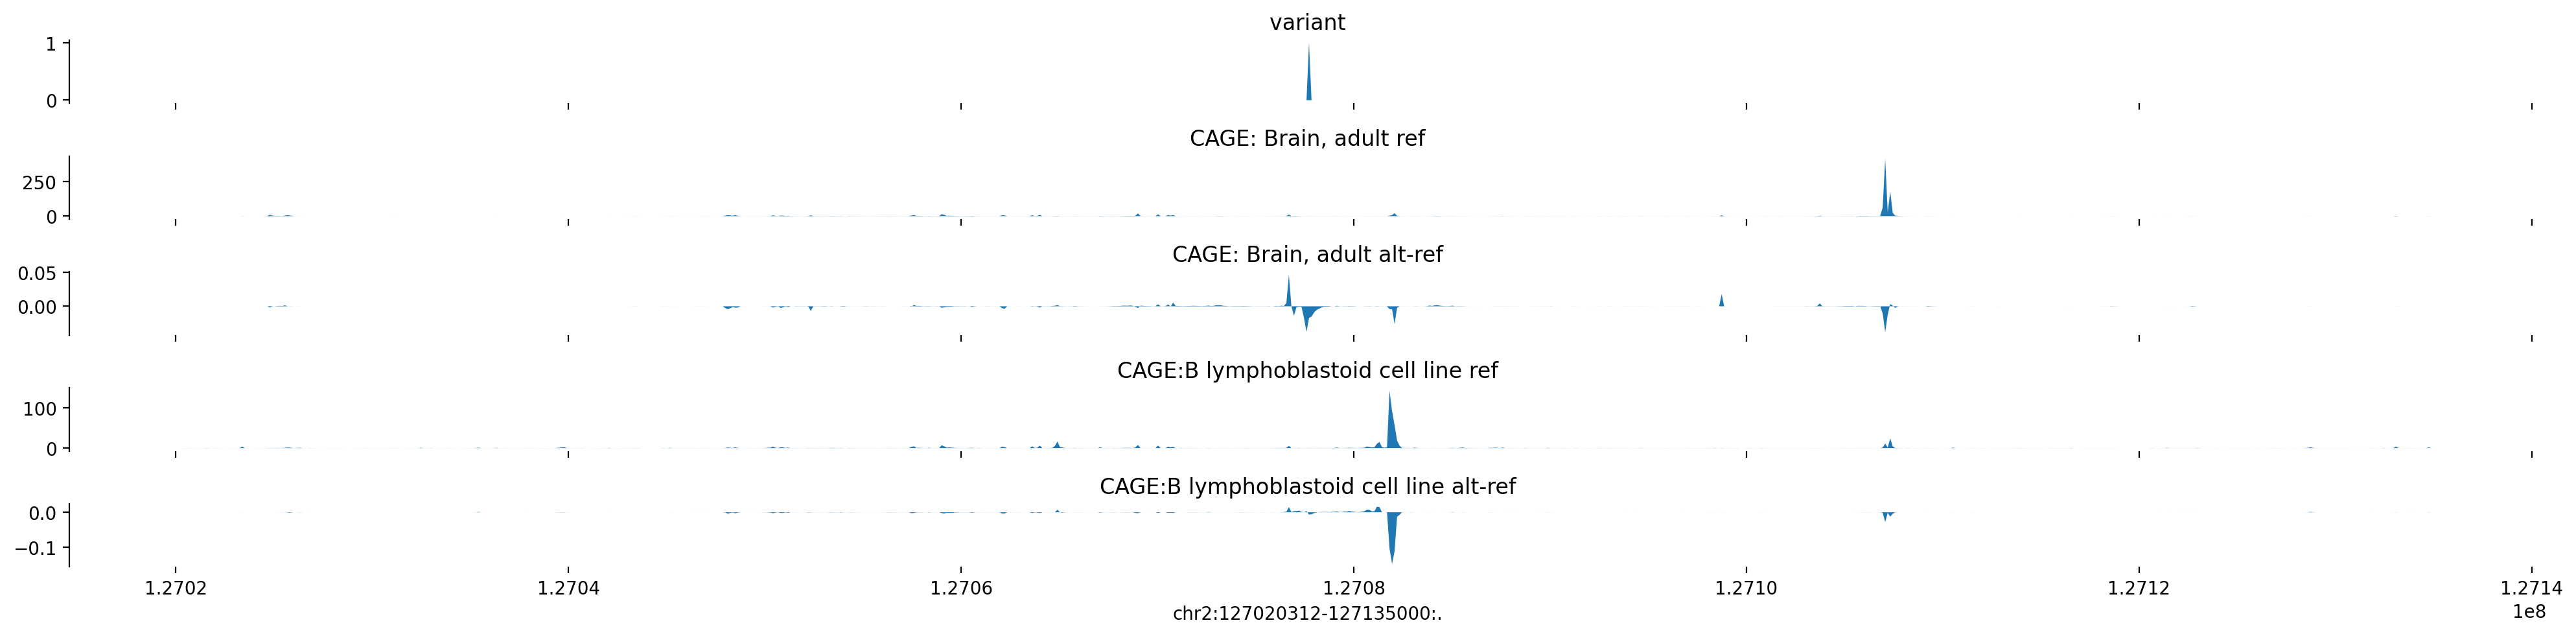

In [17]:
# @title Visualize some tracks
##plot the interval range of 114,688 bp (128bp * 896)
variant_track = np.zeros_like(reference_prediction[:, 0], dtype=bool)
variant_track[variant_track.shape[0] // 2] = True
tracks = {'variant': variant_track,
          'CAGE: Brain, adult ref': reference_prediction[:, 4680],
          'CAGE: Brain, adult alt-ref': alternate_prediction[:, 4680] - reference_prediction[:, 4680],
          'CAGE:B lymphoblastoid cell line ref': reference_prediction[:, 5110],
          'CAGE:B lymphoblastoid cell line alt-ref': alternate_prediction[:, 5110] - reference_prediction[:, 5110],
          }

plot_tracks(tracks, interval.resize(reference_prediction.shape[0] * 128), height=1)

In [ ]:
alternate_prediction.shape

(896, 5313)

## PCs


In [15]:
## report top 20 pcs
enformer_score_variants = EnformerScoreVariantsPCANormalized(model_path, transform_path, num_top_features=20)

2023-02-28 22:51:14.672181: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".
/gpfs/commons/home/tlin/miniconda3/envs/enformer/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/gpfs/commons/home/tlin/miniconda3/envs/enformer/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning:

In [16]:
# Score the first 5 variants from ClinVar
# Lower-dimensional scores (20 PCs)
it = variant_centered_sequences(clinvar_vcf, sequence_length=SEQUENCE_LENGTH,
                                gzipped=True, chr_prefix='chr')
example_list = []
for i, example in enumerate(it):
  if i >= 5:
    break
  variant_scores = enformer_score_variants.predict_on_batch(
      {k: v[tf.newaxis] for k,v in example['inputs'].items()})[0]
  variant_scores = {f'PC{i}': score for i, score in enumerate(variant_scores)}
  example_list.append({**example['metadata'],
                       **variant_scores})
df = pd.DataFrame(example_list)
df

,chrom,pos,id,ref,alt,PC0,PC1,PC2,PC3,PC4,...,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
0,chr1,69134,2205837,A,G,-7.429755,2.267157,-4.216339,7.757829,1.581988,...,1.202305,-0.871081,-5.366755,1.529922,-1.950853,4.245354,2.408810,-0.615990,-1.739641,0.807775
1,chr1,69581,2252161,C,G,-2.233457,4.261683,-6.350932,2.498366,-2.610144,...,-1.176664,1.512286,-2.998013,0.623253,-0.048804,1.530766,0.661219,-0.001857,-2.143385,0.974198
2,chr1,69682,2396347,G,A,-8.019966,4.185019,-6.304610,6.836575,-0.562589,...,0.038046,1.210563,-9.287879,2.817811,-1.255036,5.417985,1.267830,-1.760575,-3.680439,0.831225
3,chr1,69769,2288999,T,C,-5.981121,1.302731,-2.802442,2.191287,-0.429811,...,0.604276,-0.166562,-1.652760,0.070685,0.325672,2.219738,1.764475,-1.870098,-2.680223,0.910356
4,chr1,69995,2351346,G,C,-2.020139,0.913131,-1.719384,1.568020,-0.250697,...,0.330600,0.086615,-0.864896,0.322758,-0.600628,0.949337,0.183429,0.494965,0.371392,-0.111396


In [13]:
enformer_score_variants_all = EnformerScoreVariantsNormalized(model_path, transform_path)

/gpfs/commons/home/tlin/miniconda3/envs/enformer/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/gpfs/commons/home/tlin/miniconda3/envs/enformer/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator TruncatedSVD from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/gpfs/commons/home/tlin/miniconda3/envs/enformer/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator Pipeline from versio

In [49]:
for i , example in enumerate(it):
    print(example)
    break

{'inputs': {'ref': array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       ...,
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ]], dtype=float32), 'alt': array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       ...,
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ]], dtype=float32)}, 'metadata': {'chrom': 'chr1', 'pos': 69134, 'id': '2205837', 'ref': 'A', 'alt': 'G'}}


In [41]:
enformer = Enformer.from_pretrained('EleutherAI/enformer-official-rough')

In [35]:
1536*128

196608